In [26]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.express as px

# Model

In [27]:
df = yf.download("AAPL")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600


In [28]:
fig = px.line(df, x=df.index, y='Close',title = 'TSLA Close Price')
fig.show()

In [29]:
data = df.filter(['Close'])

dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

8476

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[4.35483657e-04],
       [3.98684577e-04],
       [3.49613595e-04],
       ...,
       [7.86767429e-01],
       [7.49891336e-01],
       [7.38954889e-01]])

In [31]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        pass
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [32]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Activation

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = model.fit(x_train, y_train, batch_size=32, epochs=5)

Epoch 1/10
263/263 [==============================] - 22s 65ms/step - loss: 3.3065e-05 - mean_squared_error: 3.3065e-05
Epoch 2/10
263/263 [==============================] - 18s 67ms/step - loss: 1.3448e-05 - mean_squared_error: 1.3448e-05
Epoch 3/10
263/263 [==============================] - 17s 66ms/step - loss: 1.2409e-05 - mean_squared_error: 1.2409e-05
Epoch 4/10
263/263 [==============================] - 18s 67ms/step - loss: 1.0412e-05 - mean_squared_error: 1.0412e-05
Epoch 5/10
263/263 [==============================] - 23s 89ms/step - loss: 9.4035e-06 - mean_squared_error: 9.4035e-06
Epoch 6/10
263/263 [==============================] - 19s 72ms/step - loss: 9.2444e-06 - mean_squared_error: 9.2444e-06
Epoch 7/10
263/263 [==============================] - 18s 70ms/step - loss: 9.8663e-06 - mean_squared_error: 9.8663e-06
Epoch 8/10
263/263 [==============================] - 18s 69ms/step - loss: 9.4691e-06 - mean_squared_error: 9.4691e-06
Epoch 9/10
263/263 [====================

In [33]:

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)


x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE score:",rmse)

67/67 [==============================] - 3s 33ms/step
RMSE score: 2.978681423675702


In [34]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\oktay\AppData\Local\Temp\ipykernel_15924\2657761684.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



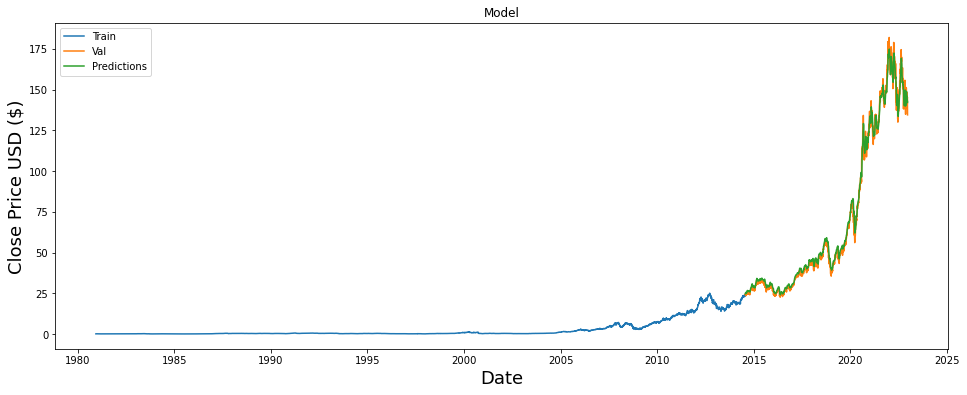

In [35]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [36]:
valid

,Close,Predictions
Date,,
2014-07-23,24.297501,24.759558
2014-07-24,24.257500,24.831490
2014-07-25,24.417500,24.949581
2014-07-28,24.754999,25.098665
2014-07-29,24.594999,25.290087
...,...,...
2022-12-12,144.490005,143.053238
2022-12-13,145.470001,142.792694
2022-12-14,143.210007,142.919830


In [37]:
fig = px.line(valid, x=valid.index, y=['Close', 'Predictions'])
fig.show()